In [3]:
from IPython.display import Image

Trying to re-implement the 2d cylindrical viscosity using 2nd derivs directly rather than calculating q matrix from velocity differential then taking derivatives of those elements.  
the viscous force is given as:  
$f_{vr} = \frac{\partial \tau_{1,1}}{\partial r} + \frac{\tau_{1,1}}{r} - \frac{\tau_{2,2}}{r} + \frac{\partial \tau_{1,3}}{\partial z}$  

$f_{v\theta} = \frac{\partial \tau_{1,2}}{\partial r} +2 \frac{\tau_{1,2}}{r} +\frac{\partial  \tau_{2,3}}{\partial z}$  

$f_{vz} = \frac{\partial \tau_{1,3}}{\partial r} + \frac{\tau_{1,3}}{r} + \frac{\partial \tau_{3,3}}{\partial z}$

Where the elements of $\tau$ are given by:

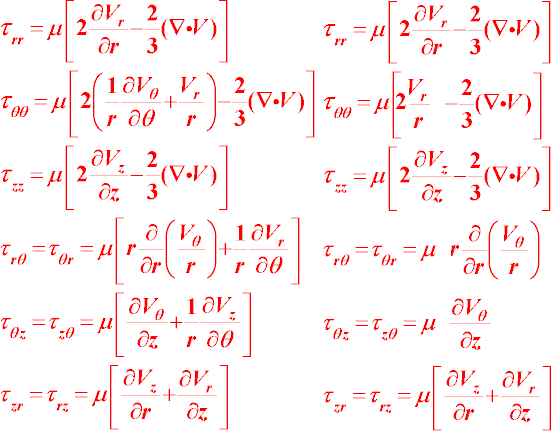

In [3]:
Image(filename='/Users/tdouglas/Documents/notebooks/logbooks/stress.png')

with $\nabla \cdot V = \frac{\partial V_r}{\partial r} +V_r/r + \frac{\partial V_z}{\partial z}$ and using axis-symmetry $\left( \frac{\partial X}{\partial \theta} \equiv 0 \right)$ we can use Sympy to do the algebra:

In [6]:
from sympy import Function, Symbol, init_printing
init_printing()
r=Symbol('r')
z=Symbol('z')
m=Symbol('\mu')
u=Function('u')(r,z)
v=Function('v')(r,z)
w=Function('w')(r,z)

divV=u.diff(r)+u/r+w.diff(z)

t11=m*(2*u.diff(r)-2*divV/3)
t22=m*(2*u/r-2*divV/3)
t33=m*(2*w.diff(z)-2*divV/3)
t12=m*(r*(v/r).diff(r))
t13=m*(w.diff(r)+u.diff(z))
t23=m*(v.diff(z))

f_r    =t11.diff(r)+t11/r-t22/r+t13.diff(z)
f_theta=t12.diff(r)+2*t12/r+t23.diff(z)
f_z    =t13.diff(r)+t13/r+t33.diff(z)

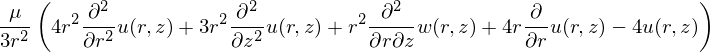

In [7]:
f_r.simplify()

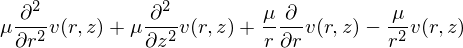

In [8]:
f_theta.simplify()

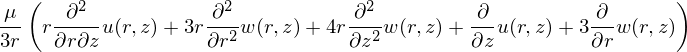

In [9]:
f_z.simplify()

Where $u,v,w = V_r,V_\theta,V_z$

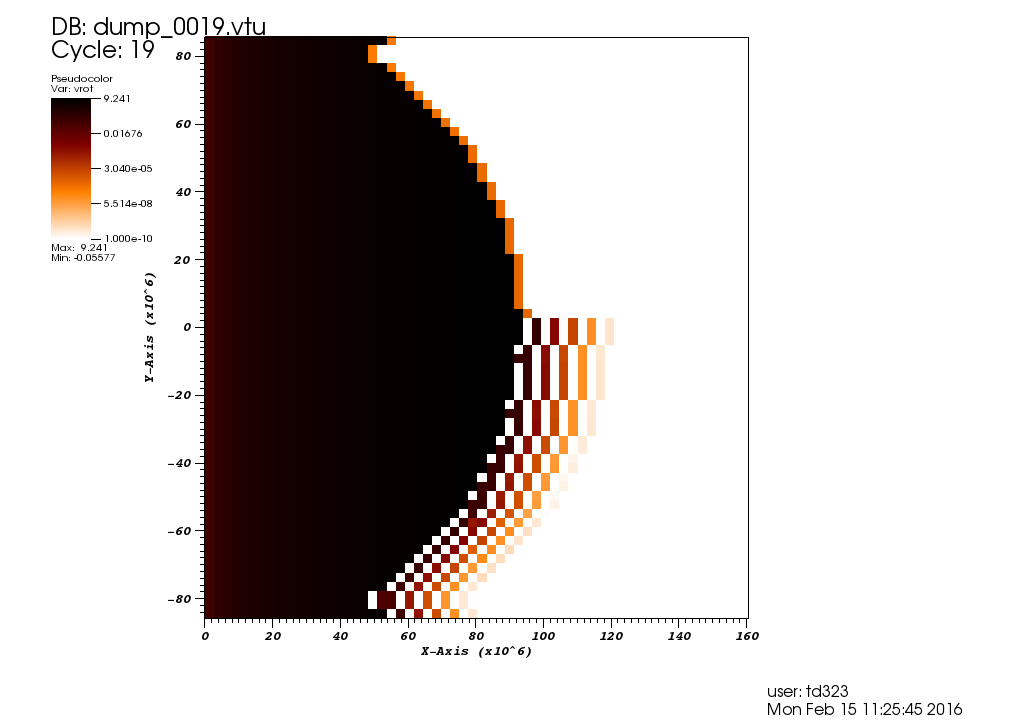

In [4]:
Image(filename='/Users/tdouglas/Documents/notebooks/logbooks/viscosity_new.png')

If we ignore the problems of missing corner values across mpi domains we can look at how the new method performs within the domains. Below is a figure using the new method for +ve Z cells and the old (original, cell based derivatives) method for the -ve Z ones.

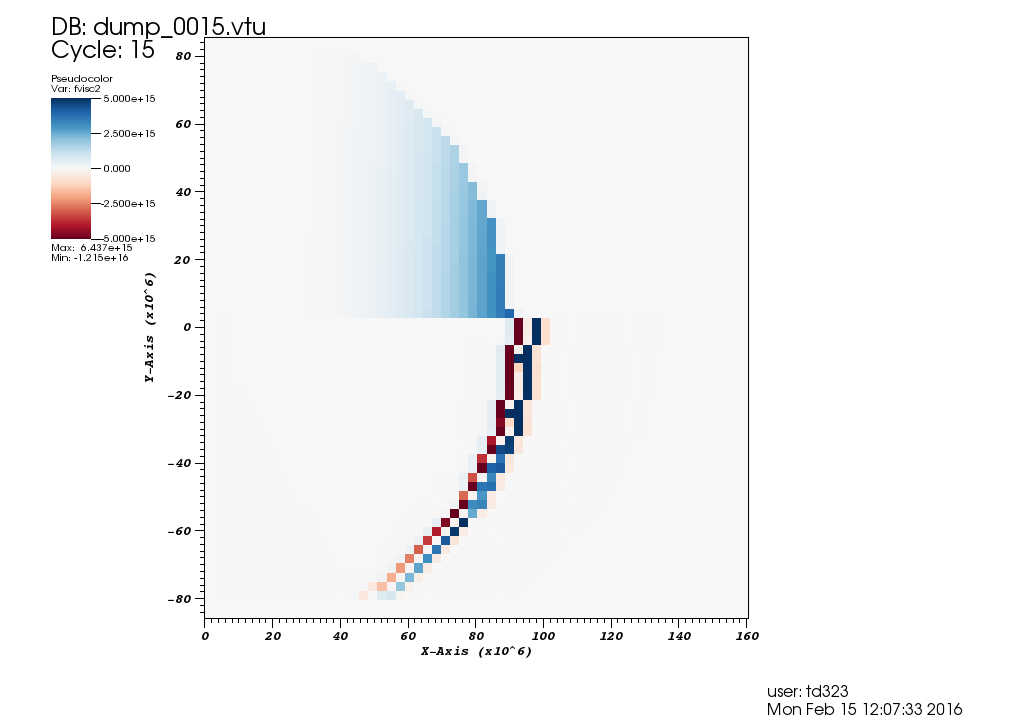

In [5]:
Image(filename='/Users/tdouglas/Documents/notebooks/logbooks/viscosity_force_new.png')

OLD by hand algebra



(r=1, $\theta$=2, z=3) $\omega = v_\theta /r $ and as we are assuming axis-symmetry all $\frac{\partial }{\partial \theta}$ terms vanish, and  
$\nabla \cdot V = \frac{\partial V_r}{\partial r} +V_r/r + \frac{\partial V_z}{\partial z}$  
so the viscous forces are:  

$f_{vr} = \mu \left[ 2\frac{\partial^2 V_r}{\partial r^2} -\frac{2}{3} \frac{\partial \nabla \cdot V}{\partial r} + \frac{2}{r} \frac{\partial V_r}{\partial r} - 2\frac{V_r}{r^2} + \left( \frac{\partial^2 V_z}{\partial r \partial z} +\frac{\partial^2 V_r }{\partial z^2} \right) \right]$  

$f_{v\theta} = \mu \left [\left( \frac{\partial \omega}{\partial r} + r \frac{\partial^2 \omega}{\partial r^2} \right)+2 \frac{\partial \omega}{\partial r} + \frac{\partial^2 V_z}{\partial z^2} \right]$  

$f_{vz} = \mu \left[\frac{\partial^2 V_z}{\partial r^2} + \frac{\partial^2 V_r}{\partial r \partial z} + \frac{1}{r} \left( \frac{\partial V_z}{\partial r} +\frac{\partial V_r}{\partial z} \right) + 2 \frac{\partial^2 V_z}{\partial z^2} - \frac{2}{3} \frac{\partial \nabla \cdot V}{\partial z} \right]$

subbing in 
$\frac{\partial \nabla \cdot V}{\partial x} = \frac{\partial^2 V_r}{\partial r \partial x} + \frac{\partial V_r/r}{\partial x} + \frac{\partial^2 V_z}{\partial z \partial x}$  
gives:  

$f_{vr} = \mu \left[ 2\frac{\partial^2 V_r}{\partial r^2} -\frac{2}{3} \left( \frac{\partial^2 V_r}{\partial r^2} + \frac{\partial V_r/r}{\partial r} + \frac{\partial^2 V_z}{\partial z \partial r} \right) + \frac{2}{r} \frac{\partial V_r}{\partial r} - 2\frac{V_r}{r^2} + \left( \frac{\partial^2 V_z}{\partial r \partial z} +\frac{\partial^2 V_r }{\partial z^2} \right) \right]$  

$f_{v\theta} = \mu \left [\left( \frac{\partial \omega}{\partial r} + r \frac{\partial^2 \omega}{\partial r^2} \right)+2 \frac{\partial \omega}{\partial r} + \frac{\partial^2 V_z}{\partial z^2} \right]$  

$f_{vz} = \mu \left[\frac{\partial^2 V_z}{\partial r^2} + \frac{\partial^2 V_r}{\partial r \partial z} + \frac{1}{r} \left( \frac{\partial V_z}{\partial r} +\frac{\partial V_r}{\partial z} \right) + 2 \frac{\partial^2 V_z}{\partial z^2} - \frac{2}{3} \left (\frac{\partial^2 V_r}{\partial r \partial z} + \frac{\partial V_r/r}{\partial z} + \frac{\partial^2 V_z}{\partial z^2} \right) \right]$  

$\frac{\partial V_r/r}{\partial r}$ expands to $\frac{1}{r}\frac{\partial V_r}{\partial r} - \frac{V_r}{r^2}$

which simplifies to:  

$f_{vr} = \mu \left[ \frac{4}{3} \frac{\partial^2 V_r}{\partial r^2} +  \frac{1}{3} \frac{\partial^2 V_z}{\partial r \partial z} +\frac{\partial^2 V_r }{\partial z^2} + \frac{4}{3r} \frac{\partial V_r}{\partial r} - \frac{4}{3}\frac{V_r}{r^2} \right]$  

$f_{v\theta} = \mu \left [ r \frac{\partial^2 \omega}{\partial r^2}  + \frac{\partial^2 V_z}{\partial z^2}+3 \frac{\partial \omega}{\partial r} \right]$  

$f_{vz} = \mu \left[\frac{\partial^2 V_z}{\partial r^2} + \frac{1}{3}\frac{\partial^2 V_r}{\partial r \partial z} + \frac{4}{3} \frac{\partial^2 V_z}{\partial z^2} + \frac{1}{r} \frac{\partial V_z}{\partial r} +\frac{1}{3r} \frac{\partial V_r}{\partial z} \right]$  

stuff to do to implement mpi passing of corner values:   
octalmod to declare the array  
change copy octal compo in amr_mod : copys pointers to another octal  
deallococtal dynamic attrib amr_mod : call to deallocate the array  
allocateoctalatrrib allocate the array in the if(hydrodynamics)  
  
mpi_amr_mod  
recieveacrossmpiboundary  
exchangeacrossmpiboundary  
getneighbourvalues  
search qVisc in here  
nstorage  

ignore exchange...level

Ugh, svn horribleness trying to merge the trunk back in has broke everything.  
tring to start from the trunk and re-implement my changes, but somehow line driving has broken. Fortunately it still works in (a clean version of) my branch so I just need to do a full diff or the relevent files (amr, mpiamr, photoion, photoionamr, hydrodynamics) and find out what I've missed